<a href="https://colab.research.google.com/github/lukekolbe/AL-in-CreditScoring/blob/main/threshold_tuner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [2]:
############ LIBRARIES

import os
import random
import multiprocessing
import pickle
import copy
import gc
import sys
import json
gc.enable()

import warnings
warnings.filterwarnings('ignore')


import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold  ##### what is this used for?
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


############ RANDOMNESS
# seed function
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    
# set seed
seed = 30
seed_everything(seed)


In [3]:
os.chdir('/gdrive/My Drive/ACTIVE LEARNING THESIS/')

In [ ]:
'''if len(y) > 25000:
    validation_size = 5000
    folds = 3
    sss = StratifiedShuffleSplit(n_splits=1, test_size=validation_size, random_state=seed) #
    for model, validation in sss.split(X=X, y=y):
        model_idx, validation_idx = np.asarray(model), np.asarray(validation)

    print(np.sum(model_idx), np.sum(validation_idx))
    X_val, y_val = X[validation_idx,:], y[validation_idx]
    #X_model, y_model = X[model_idx,:], y[model_idx]

elif len(y) < 2000:
    folds = 10
    X_val, y_val = X, y

else:
    folds = 5
    X_val, y_val = X, y
    
print(np.shape(X), np.shape(X_val), 'folds: ', folds)'''

In [4]:
folds = 10
#X_val, y_val = X, y

In [5]:
# loader function that unpacks tuning results and extracts parameters for different model steps

def param_getter(tuned=False, dataset=None):
  if tuned:
    filename = f'{dataset}_tuned-params'

    with open(filename, 'r') as f:
      param_list = [json.loads(line) for line in f if line.startswith('{')]

    param_dict = {}
    for i in range(len(param_list)):
      strategy_short = list(param_list[i].keys())[0]
      param_dict[strategy_short] = param_list[i][list(param_list[i].keys())[0]]

  else:
    param_dict = {'oracle': {'strategy_name': 'Oracle'}
                  ,'score': {'strategy_name': 'Score'}
                  ,'random': {'strategy_name': 'QueryInstanceRandom'}
                  ,'unc': {'strategy_name': 'QueryInstanceUncertainty'}
                  ,'qbc': {'strategy_name': 'QueryInstanceQBC'}
                  ,'eer': {'strategy_name': 'QueryExpectedErrorReduction'}
                  ,'dw': {'strategy_name': 'QueryInstanceDensityWeighted'}
                  ,'density':{'strategy_name': 'QueryInstanceGraphDensity'}
                  ,'cors' :  {'strategy_name': 'QueryInstanceCoresetGreedy'}
                  ,'quire': {'strategy_name': 'QueryInstanceQUIRE'}
                  ,'bmdr': {'strategy_name': 'QueryInstanceBMDR'}
                  ,'spal': {'strategy_name': 'QueryInstanceSPAL'}
                  ,'lal': {'strategy_name': 'QueryInstanceLAL'}
                  }
  
  return param_dict

In [6]:
def cost_tuner(y, pred_raw, y_mean, thres_array, fn_cost = None):
  if fn_cost == None:
    fn_cost = (1-y_mean)/y_mean # set fn cost to the inverse of the probability of the rare class; fix cost of fp to 1
  
  #print(fn_cost)

  cost_list = []
  for t in thres_array:
    pred_thres =  (pred_raw[:,1] >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, pred_thres).ravel()
    cost = fp + fn*fn_cost
    cost_list.append(cost)


  return cost_list

'''  cost_min = min(cost_list)
  cost_min_index = cost_list.index(cost_min)
  best_thres = thres_arr.index(cost_min_index)'''



'  cost_min = min(cost_list)\n  cost_min_index = cost_list.index(cost_min)\n  best_thres = thres_arr.index(cost_min_index)'

In [7]:
def threshold_finder(X,y,dataset,folds):
  param_dict = param_getter(tuned=True, dataset=dataset) # load tuned parameters
  clf = LogisticRegression(**param_dict['random']['CLF']) #set up tuned classifier
  
  skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state=seed)
  idx = []
  for train_index, test_index in skf.split(X, y):
    idx.append((train_index, test_index))

  cost_list = []
  thres_arr =  [i for i in iter(np.linspace(0, 1, 1001))]

  for f in range(folds-1):
    train_idx = idx[f][0]
    test_idx = idx[f][1]

    clf.fit(X[train_idx,:], y[train_idx])
    probabilities = clf.predict_proba(X[test_idx,:])

    y_mean = np.mean(y[train_idx])

    cost_list.append(cost_tuner(y[test_idx], probabilities, y_mean, thres_arr, fn_cost = None))

  mean_cost = np.mean(cost_list, axis = 0)
  cost_min = min(mean_cost)
  cost_min_index = np.where(mean_cost == mean_cost.min())[0][0]
  best_thres = thres_arr[cost_min_index]

  return best_thres



In [8]:
############ DATA IMPORT

## available datasets
# bene1         # some 

    # OK gmsc          # shape:  (150000, 68)
    # OK uk            # very low bad rate, shape:  (30000, 51), y mean:  0.04
    # OK lendingclub   # loooow performance, X shape:  (41623, 114) y shape:  (41623,) y mean:  0.1331235134420873    
    
    # OK bene2         # some learning, shape:  (7190, 28) >> 3 folds NO WASTE
    
    # bene1_nobins  # shape:  (3123, 18) # 5 folds NO WASTE
        # hmeq          # not promising either, shape:  (5960, 20) # 5 folds NO WASTE
        # australian    # very small dataset shape:  (690, 42) >> 10 folds NO WASTE
        # german        # shape:  (1000, 61) >> 10 folds NO WASTE
        # thomas        # loooow performance shape:  (1225, 28) >> 10 folds NO WASTE

# pakdd         # shape:  (50000, 373), y mean:  0.26082

data_name = "bene2"
dataset_list = ["bene2", "bene1_nobins","gmsc", "uk", "lendingclub", "hmeq", "australian", "german", "thomas", "pakdd"]

def data_loader(dataset):

  # C:\\Users\\kolbeluk1\\AL_THESIS
  #df = pd.read_csv('C:\\Users\\kolbeluk1\\AL_THESIS\\prepared_data\\{}.csv'.format(dataset))
  df = pd.read_csv('/gdrive/My Drive/ACTIVE LEARNING THESIS/prepared_data/{}.csv'.format(dataset))

  # remove NA
  df = df.dropna()
  df.reset_index(drop = True, inplace = True)

  #print(df)
  # extract label
  df['BAD'][df['BAD']=='BAD']  = 1
  df['BAD'][df['BAD']=='GOOD'] = 0
  df['BAD'] = df['BAD'].astype('int')


  y_temp = df['BAD']
  del df['BAD']

  #one hot encoding
  df = pd.get_dummies(df)

  #transform to numpy array >> same location for df and X
  X = df.to_numpy()
  y = y_temp.to_numpy()

  print("X type: ", type(X), "X shape: ",X.shape,"y shape: ", y.shape, "y mean: ", np.mean(y))
  print (id(X), id(df))
  #print(y)

  return X,y


# append_record: helper function that adds best-parameter for every model to dict and saves it
def append_record(record, filename):
    with open(f'{filename}', 'a') as f:
        json.dump(record, f)
        f.write(os.linesep)

filename = 'tuned_thresholds'

In [ ]:
threshold_dict = {}
for d in dataset_list:
  X,y = data_loader(d)

  cost_threshold = threshold_finder(X, y, d, 10)

  threshold_dict[f'{d}'] = copy.deepcopy(cost_threshold)

  with open(f'{filename}', 'wb') as a_file:
    pickle.dump(threshold_dict, a_file)

a_file.close()

X type:  <class 'numpy.ndarray'> X shape:  (7190, 28) y shape:  (7190,) y mean:  0.3
139635390439312 139635463126096
X type:  <class 'numpy.ndarray'> X shape:  (3123, 18) y shape:  (3123,) y mean:  0.3333333333333333
139635391124080 139635462958992
X type:  <class 'numpy.ndarray'> X shape:  (150000, 68) y shape:  (150000,) y mean:  0.06684
139635463249808 139635464531792
X type:  <class 'numpy.ndarray'> X shape:  (30000, 51) y shape:  (30000,) y mean:  0.04
139635391124080 139635463021840
X type:  <class 'numpy.ndarray'> X shape:  (41623, 114) y shape:  (41623,) y mean:  0.1331235134420873
139635391123600 139635463021584
X type:  <class 'numpy.ndarray'> X shape:  (5960, 20) y shape:  (5960,) y mean:  0.199496644295302
139635390438640 139635833966736
X type:  <class 'numpy.ndarray'> X shape:  (690, 42) y shape:  (690,) y mean:  0.4449275362318841
139635390438448 139635463864784
X type:  <class 'numpy.ndarray'> X shape:  (1000, 61) y shape:  (1000,) y mean:  0.3
139635463249808 139635391

In [ ]:
infile = open(f'{filename}','rb')
tuned_thresholds = pickle.load(infile)
infile.close()

tuned_thresholds

{'australian': 0.428,
 'bene1_nobins': 0.34600000000000003,
 'bene2': 0.334,
 'german': 0.309,
 'gmsc': 0.056,
 'hmeq': 0.241,
 'lendingclub': 0.136,
 'pakdd': 0.275,
 'thomas': 0.254,
 'uk': 0.041}

# RUN FOR SINGLE DATASET

In [10]:
data_name = "bene1_nobins"

X,y = data_loader(data_name)
#filename = f'{data_name}_threshold'


X type:  <class 'numpy.ndarray'> X shape:  (3123, 18) y shape:  (3123,) y mean:  0.3333333333333333
139701778341936 139701204717136


In [11]:
param_dict = param_getter(tuned=True, dataset = data_name) # load tuned parameters
clf = LogisticRegression(**param_dict['random']['CLF'])
print(clf)

LogisticRegression(C=0.1, max_iter=50, penalty='l1', solver='liblinear')


(10, 2)
y mean of fold 0:  0.3330960854092527
FN cost (if computed):  2.002136752136752
y mean of fold 1:  0.3334519572953737
FN cost (if computed):  1.998932764140875
y mean of fold 2:  0.3334519572953737
FN cost (if computed):  1.998932764140875
y mean of fold 3:  0.3333333333333333
FN cost (if computed):  2.0000000000000004
y mean of fold 4:  0.3333333333333333
FN cost (if computed):  2.0000000000000004
y mean of fold 5:  0.3333333333333333
FN cost (if computed):  2.0000000000000004
y mean of fold 6:  0.3333333333333333
FN cost (if computed):  2.0000000000000004
y mean of fold 7:  0.3333333333333333
FN cost (if computed):  2.0000000000000004
y mean of fold 8:  0.3333333333333333
FN cost (if computed):  2.0000000000000004
[208.22222222 199.44432586 194.22210364 190.33309617 187.6664295
 184.77754061 181.99976284 178.11087395 174.77754061 171.99976284
 169.11134878 167.44432637 164.11123045 160.44456379 158.33345268
 156.2228164  152.44503862 151.00083159 149.33404634 147.44515746
 14

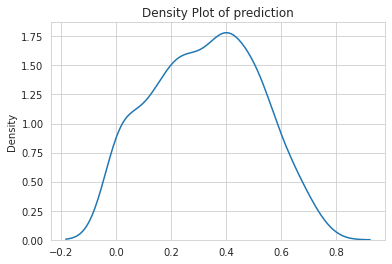

percentage kept:  0.5064102564102564
[[132  76]
 [ 26  78]]


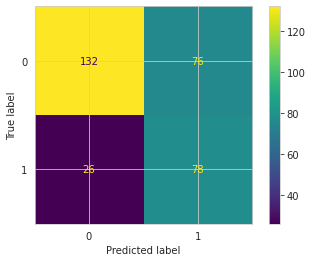

In [15]:
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state=seed)
idx = []
for train_index, test_index in skf.split(X, y):
  idx.append((train_index, test_index))

print(np.shape(idx))
cost_list = []
thres_arr =  [i for i in iter(np.linspace(0, 1, 101))]
#print(thres_arr)


for f in range(folds-1):
  train_idx = idx[f][0]
  test_idx = idx[f][1]

  clf.fit(X[train_idx,:], y[train_idx])
  probabilities = clf.predict_proba(X[test_idx,:])

  y_mean = np.mean(y[train_idx])
  print(f'y mean of fold {f}: ', y_mean)
  print('FN cost (if computed): ',(1-y_mean)/y_mean)

  cost_list.append(cost_tuner(y[test_idx], probabilities, y_mean, thres_arr, fn_cost = None))

#print(cost_list)
#print('len cost list ', len(cost_list))

mean_cost = np.mean(cost_list, axis = 0)
print(mean_cost)

cost_min = min(mean_cost)
print(cost_min)
cost_min_index = np.where(mean_cost == mean_cost.min())[0][0]
print(cost_min_index)

best_thres = thres_arr[cost_min_index]
print(best_thres)


train_idx = idx[folds-1][0]
test_idx = idx[folds-1][1]
clf.fit(X[train_idx,:], y[train_idx])
probabilities = clf.predict_proba(X[test_idx,:])
print('mean of prediction: ', np.mean(probabilities))

sns.set_style('whitegrid')
sns.kdeplot(probabilities[:,1]).set_title('Density Plot of prediction')
plt.show()
    

pred_thres = (probabilities[:,1] >= best_thres).astype(int)
print('percentage kept: ',1-np.mean(pred_thres))

disp = ConfusionMatrixDisplay.from_predictions(
    y[test_idx],
    pred_thres,
)
print(disp.confusion_matrix)

plt.show()




lendingclub
(10, 2)
y mean of fold 0:  0.13312867058195407
FN cost (if computed):  6.511529977942652
y mean of fold 1:  0.13312867058195407
FN cost (if computed):  6.511529977942652
y mean of fold 2:  0.13310197544046984
FN cost (if computed):  6.513036502206177
y mean of fold 3:  0.13312511678812633
FN cost (if computed):  6.511730499298174
y mean of fold 4:  0.13312511678812633
FN cost (if computed):  6.511730499298174
y mean of fold 5:  0.13312511678812633
FN cost (if computed):  6.511730499298174
y mean of fold 6:  0.13312511678812633
FN cost (if computed):  6.511730499298174
y mean of fold 7:  0.13312511678812633
FN cost (if computed):  6.511730499298174
y mean of fold 8:  0.13312511678812633
FN cost (if computed):  6.511730499298174
[3608.22222222 3604.28443983 3590.61777317 3564.73941194 3519.34180037
 3432.29916934 3326.4607353  3209.80734082 3110.66555401 3044.25586098
 2963.36979837 2915.86295361 2881.57109584 2860.85945484 2863.3941895
 2886.35715833 2881.31634923 2969.10442

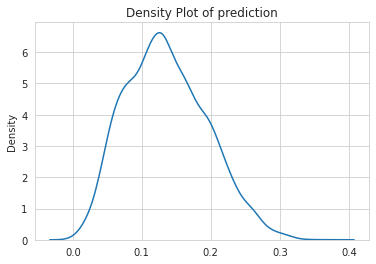

percentage kept:  0.4891878904372897
[[1867 1741]
 [ 169  385]]


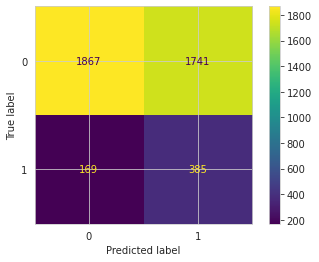

In [ ]:
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state=seed)
idx = []
for train_index, test_index in skf.split(X, y):
  idx.append((train_index, test_index))

print(data_name)
print(np.shape(idx))
cost_list = []
thres_arr =  [i for i in iter(np.linspace(0, 1, 101))]
#print(thres_arr)


for f in range(folds-1):
  train_idx = idx[f][0]
  test_idx = idx[f][1]

  clf.fit(X[train_idx,:], y[train_idx])
  probabilities = clf.predict_proba(X[test_idx,:])

  y_mean = np.mean(y[train_idx])
  print(f'y mean of fold {f}: ', y_mean)
  print('FN cost (if computed): ',(1-y_mean)/y_mean)

  cost_list.append(cost_tuner(y[test_idx], probabilities, y_mean, thres_arr, fn_cost = None))

#print(cost_list)
#print('len cost list ', len(cost_list))

mean_cost = np.mean(cost_list, axis = 0)
print(mean_cost)

cost_min = min(mean_cost)
print(cost_min)
cost_min_index = np.where(mean_cost == mean_cost.min())[0][0]
print(cost_min_index)

best_thres = thres_arr[cost_min_index]
print(best_thres)


train_idx = idx[folds-1][0]
test_idx = idx[folds-1][1]
clf.fit(X[train_idx,:], y[train_idx])
probabilities = clf.predict_proba(X[test_idx,:])

sns.set_style('whitegrid')
sns.kdeplot(probabilities[:,1]).set_title('Density Plot of prediction')
plt.show()
    

pred_thres = (probabilities[:,1] > best_thres).astype(int)
print('percentage kept: ',1-np.mean(pred_thres))

disp = ConfusionMatrixDisplay.from_predictions(
    y[test_idx],
    pred_thres,
)
print(disp.confusion_matrix)

plt.show()


